# Machine Learning: Homework 2

This is the notebook containing the code and some text explanation of the second homework of Machine Learning Course, included in the Master Degree of "Artificial Intelligence and Robotics", La Sapienza University of Rome.

- **Professor**: Luca Iocchi
- **Author**: Alessia Pontiggia
- **Student ID**: 1892079
- **Report**: [latex](https://www.overleaf.com/project/6578135d0652f0a7b2396e64)


# Task explanation

The task of this second homework is a multiclass classification problem. The methodology and solutions used are explained following a sequential order.

# Import

In order to use libraries and functions not locally defined, some imports are necessary.

In [ ]:
import sys
import os
import warnings
import cv2 as cv
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from PIL import Image
from google.colab import drive


In [ ]:
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


# GPU

In [ ]:
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.15.0
Found GPU at: /device:GPU:0


In [ ]:
train_path = '/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train'
test_path = '/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test'

# Data Loading

In [ ]:
def load_dataset(path):
  dataset_split = {0: [], 1: [], 2: [], 3: [], 4:[]}
  paths = [ path+'/0/', path+'/1/', path+'/2/', path+'/3/', path+'/4/']

  idx = 0
  for path in paths:
    print(path)
    for img in os.listdir(path):
      measure = len(os.listdir(path))
      path_img = path+img
      image = cv.imread(path_img)
      dataset_split[idx].append(image)
    print("...Downloaded\n")
    idx += 1

  return dataset_split


In [ ]:
training_split = load_dataset(train_path)

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train/0/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train/1/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train/2/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train/3/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/train/4/
...Downloaded



In [ ]:
test_split = load_dataset(test_path)

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test/0/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test/1/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test/2/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test/3/
...Downloaded

/content/drive/MyDrive/AIRO/anno1/semestre1/ML/homework2/test/4/
...Downloaded



In [ ]:
def get_dimensions(split, train_val_test):

  size = 0

  if train_val_test == 'Train':
    print("\nTraining set\n")
    for key in split:
      size += len(split[key])
      print(f"Samples of class {key}: {len(split[key])}")
    print(f"Training size = {size}")
  elif train_val_test == 'Test':
    print("\nTest set\n")
    for key in split:
      size += len(split[key])
      print(f"Samples of class {key}: {len(split[key])}")
    print(f"Test size = {size}")
  else:
    print("\nValidation set\n")
    for key in split:
      size += len(split[key])
      print(f"Samples of class {key}: {len(split[key])}")
    print(f"Validation size = {size}")

  return size

In [ ]:
training_size = get_dimensions(training_split, train_val_test = 'Train')
test_size = get_dimensions(test_split, train_val_test = 'Test')


Training set

Samples of class 0: 1000
Samples of class 1: 1500
Samples of class 2: 1500
Samples of class 3: 2000
Samples of class 4: 369
Training size = 6369

Test set

Samples of class 0: 133
Samples of class 1: 275
Samples of class 2: 406
Samples of class 3: 1896
Samples of class 4: 39
Test size = 2749


In [ ]:
def plot_balance(split, train_val_test):
  if train_val_test=='Train':
    title = 'Training set balance'
  elif train_val_test == 'Val':
    title =  'Validation set balance'
  else:
    title = 'Test set balance'

  plt.bar([0,1,2,3,4], [len(split[0]), len(split[1]), len(split[2]), len(split[3]), len(split[4])])
  plt.xlabel('Labels')
  plt.ylabel('Samples')
  plt.title(title)
  return

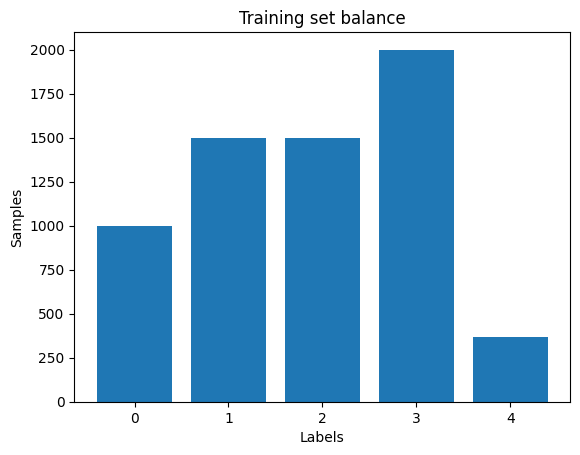

In [ ]:
plot_balance(training_split, train_val_test='Train')

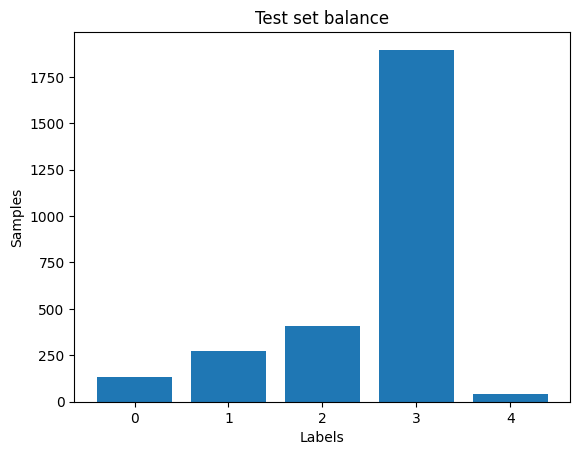

In [ ]:
plot_balance(test_split, train_val_test='Test')

## Data dimensions

In order to understand the input dimensions is useful to get them first.

In [ ]:
print(f"Dimension of images in the dataset {training_split[0][0].shape}")

Dimension of images in the dataset (96, 96, 3)


## Data sample

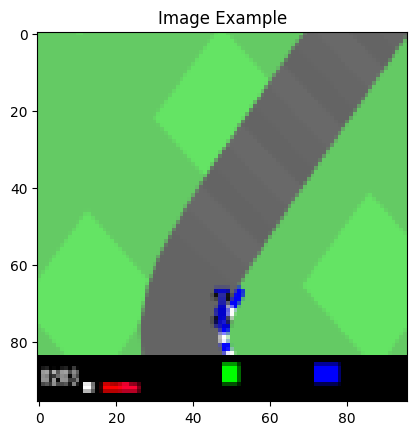

In [ ]:
sample_img = training_split[0][0]
plt.imshow(sample_img)
plt.title('Image Example')
plt.show()

# Data Preprocessing

## Unbalance

Since the dataset is unbalanced, we see in what percentage for each class we should balance it.

In [ ]:
def class_to_balance(split, train_test):

  classes = 5
  sizes = []
  for key in split:
    sizes.append(len(split[key]))

  if train_test == 'Train':
    desired_size = max(sizes)
  elif train_test == 'Test':
    desired_size = max(sizes)

  to_balance = []
  for key in split:
    if len(split[key]) < desired_size:
      to_balance.append(key)

  return to_balance, desired_size

In [ ]:
training_class_to_balance, training_desired_size = class_to_balance(training_split, 'Train')
print("Training set\n")
for c in training_class_to_balance:
  print(f"Class to balance {c}:")
  print(f"   From size {len(training_split[c])} to desired size {training_desired_size}")

Training set

Class to balance 0:
   From size 1000 to desired size 2000
Class to balance 1:
   From size 1500 to desired size 2000
Class to balance 2:
   From size 1500 to desired size 2000
Class to balance 4:
   From size 369 to desired size 2000


In [ ]:
test_class_to_balance, test_desired_size = class_to_balance(test_split, 'Test')
print("Test set\n")
for c in test_class_to_balance:
  print(f"Class to balance {c}:")
  print(f"   From size {len(test_split[c])} to desired size {test_desired_size}")

Test set

Class to balance 0:
   From size 133 to desired size 1896
Class to balance 1:
   From size 275 to desired size 1896
Class to balance 2:
   From size 406 to desired size 1896
Class to balance 4:
   From size 39 to desired size 1896


# Game

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import sys

try:
    import gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model):

    seed = 2000
    obs = env.reset(seed=seed)

    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,_,_,_ = env.step(action0)

    done = False
    while not done:
        obs = np.expand_dims(obs, axis = 0)
        p = model.predict(obs) # adapt to your model
        action = np.argmax(p)  # adapt to your model
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated




env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# your trained

play(env, model_aug)
